<h1 align="center"> Lung Segmentation with VGG16 backbone as feature extractor and XGBoost as classifier </h1>
<p align="center"><img src="diagramm.PNG"/></p>
<p align="center">
Deep Learning is known to do really well in segmentation tasks if there is enough data to learn from. 
</p>
<p align="center"> 
But up to a specific amount of training data, traditional machine learning (e.g. random forrest and xgboost) tends to perform better.
</p>
<p align="center">
This notebook investigates what a deep neural net as feature extractor and xgboost as classifier can archive on the task of lung segmentation.
</p>

<p align="center">
        <img src="seg.PNG" />
</p>
<p align="center">
<a href="https://www.kaggle.com/datasets/nikhilpandey360/chest-xray-masks-and-labels">https://www.kaggle.com/datasets/nikhilpandey360/chest-xray-masks-and-labels</a>
</p>

#### Imports

In [3]:
# imports
import pandas as pd
import numpy as np
import cv2 
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns
from glob import glob
import pickle
from keras.models import Model          
from keras.applications import VGG16, ResNet50
import xgboost as xgb
from private_path import seg_img_path, seg_mask_path, test_img_path, test_mask_path
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
model = xgb.XGBClassifier(tree_method='gpu_hist', gpu_id=0, use_label_encoder=False)

#### Load Datapaths and plot Distribution

800 Images and 704 Masks


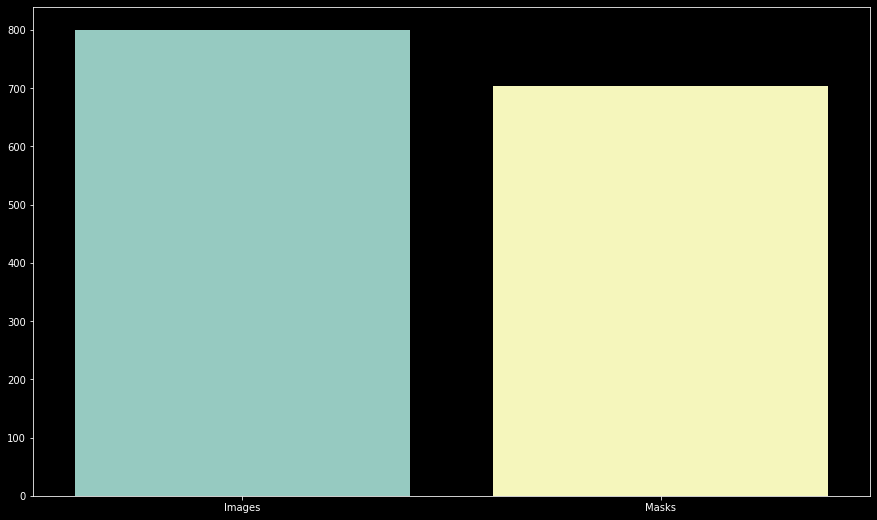

In [4]:
# Load Paths
images = glob(seg_img_path+"*.png")
masks = glob(seg_mask_path+"*.png")
# Check file distribution 
plt.figure(figsize=(15,9))
sns.barplot(x=['Images', 'Masks'], y=[len(images), len(masks)])
print(f'{len(images)} Images and {len(masks)} Masks')

Hence the amount of images and the corresponding masks are not matching, we need to do some data clean up!

#### Prepare Data for Loading

Amount of images without masks: 96
Now there are 704 Images and 704 Masks


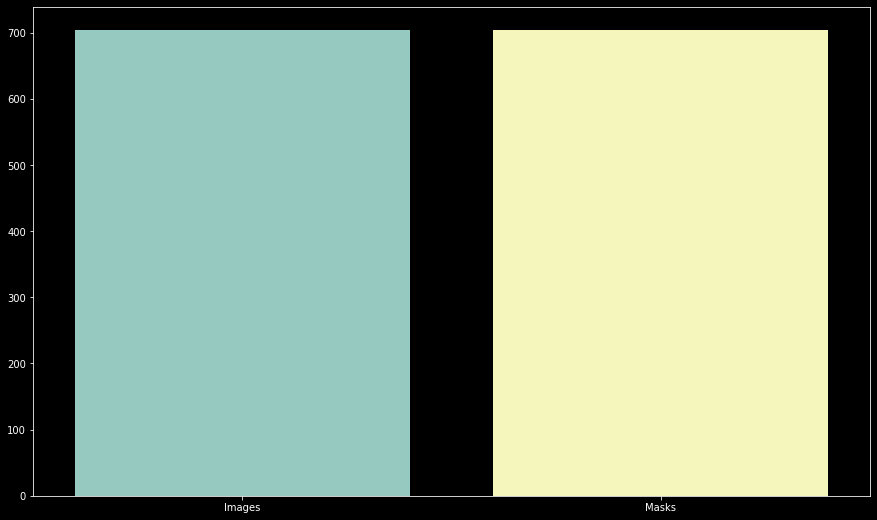

In [5]:
# First remove the "_mask" suffix in the masks path to compare the both sets more easy
s_masks = [path[:-9]+".png" if path.endswith("_mask.png") else path for path in masks]
# Isolate mask_names
mask_names = [mask[78:] for mask in s_masks]
# Now compare images with masks to find images with missing masks
images_without_mask = [image for image in images if image[80:] not in mask_names]
# replace \\ in mask path string with / 
masks = [mask.replace('\\', '/') for mask in masks]
print(f'Amount of images without masks: {len(images_without_mask)}')
# Remove Images from training data
images_cleaned = [image for image in images if image not in images_without_mask]
plt.figure(figsize=(15,9))
sns.barplot(x=['Images', 'Masks'], y=[len(images_cleaned), len(masks)])
print(f'Now there are {len(images_cleaned)} Images and {len(masks)} Masks')

Now we have the final training size of 704 Images.

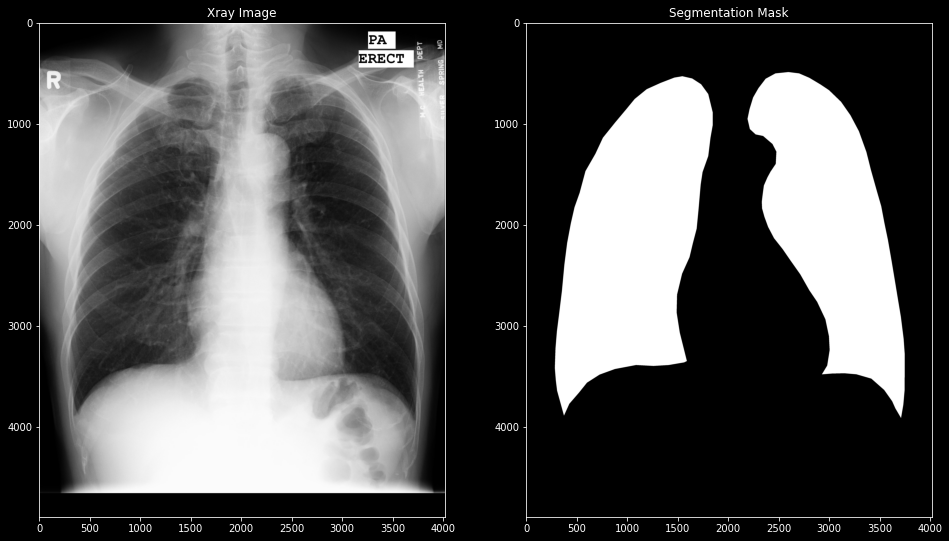

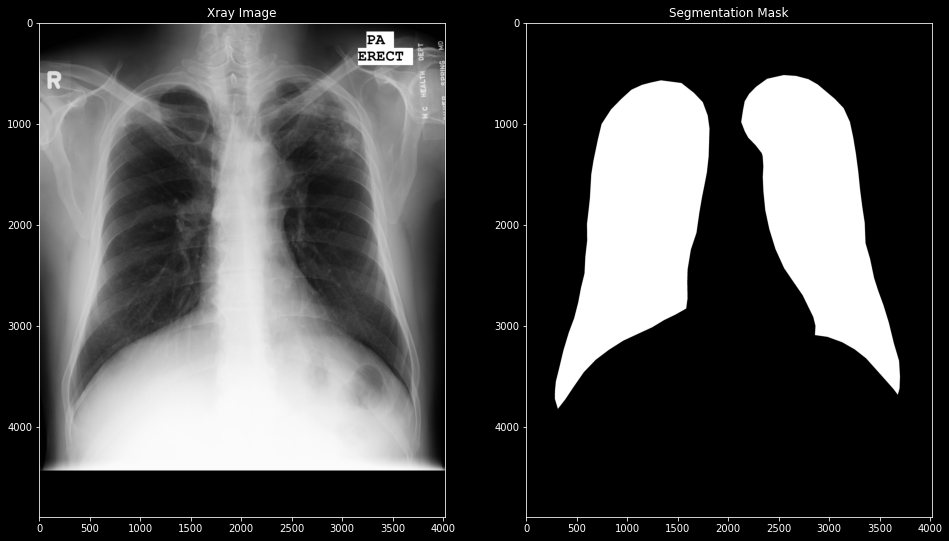

In [6]:
# Plot some examples image and mask pairs 
for i in range(700,702):
        img = cv2.imread(images_cleaned[i])
        mask = cv2.imread(masks[i])
        plt.figure(figsize=(16,10))
        plt.subplot(121)
        plt.title('Xray Image')
        plt.imshow(img)
        plt.subplot(122)
        plt.title('Segmentation Mask')
        plt.imshow(mask)
        plt.show()

In [7]:
# Loard Images
im_width = 256
im_height = 256
train_images = []
for image_path in images_cleaned[:20]:
        img = cv2.imread(image_path)
        img = cv2.resize(img,(im_height,im_width))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        #img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.cv)
        img = img/255
        train_images.append(img)
# Load train masks
train_masks = []
for mask_path in masks[:20]:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (im_height, im_width))
        # after experiencing bad predictions i noticed the pixel values of the masks are not only 0 or 255 
        # instead they have have gradients of white with less then 255 pixel valie
        # fix it by converting all values > 0 to 255 
        #mask = np.array([255 if x == 255 else 254 if 255 > x > 0 else 0  for x in mask.ravel()])
        mask = np.array([255 if x > 0 else 0 for x in mask.ravel()])
        # convert back to mask shape
        mask = np.reshape(mask, (256,256))
        mask = cv2.normalize(mask, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        train_masks.append(mask)
# Convert list of images and masks to numpy array for machine learning processing
train_images = np.array(train_images)
train_masks = np.array(train_masks)

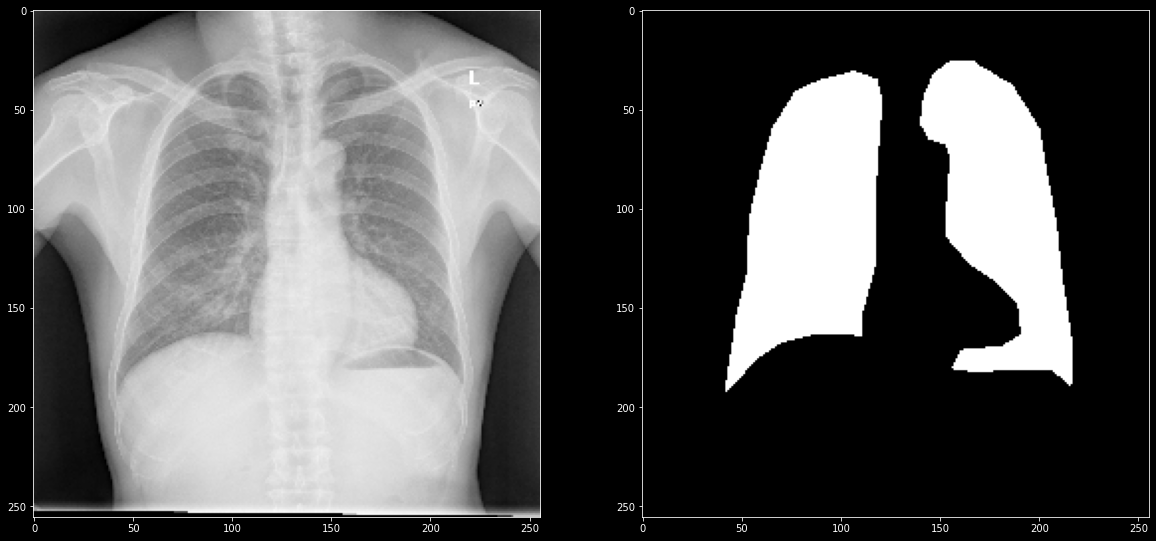

In [8]:
# Plot train-test pair after preprocessing 
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(train_images[5])
plt.subplot(122)
plt.imshow(train_masks[5], cmap='gray')

#### Load the Vgg16 model as feature extractor

In [9]:
# Load VGG model withour classifier/fc layers
# Load imagenet weights to use as feature generators 
VGG_Model = VGG16(weights='imagenet', include_top=False, input_shape=(im_height,im_width, 3))
# make loaded layers not trainable 
for layer in VGG_Model.layers:
        layer.trainable = False
# Check trainable parameter - should be 0 
VGG_Model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

After 2 convolutional layers the image would be resized - 
<p>
we only gonna take the first two layers for a new model because they match with our image dimensions.
</p>

In [10]:
feature_extractor = Model(inputs=VGG_Model.input, outputs=VGG_Model.get_layer('block1_conv2').output)
feature_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
Total params: 38,720
Trainable params: 0
Non-trainable params: 38,720
_________________________________________________________________


#### Plot feature map examples

1/1 [==============================] - 4s 4s/step


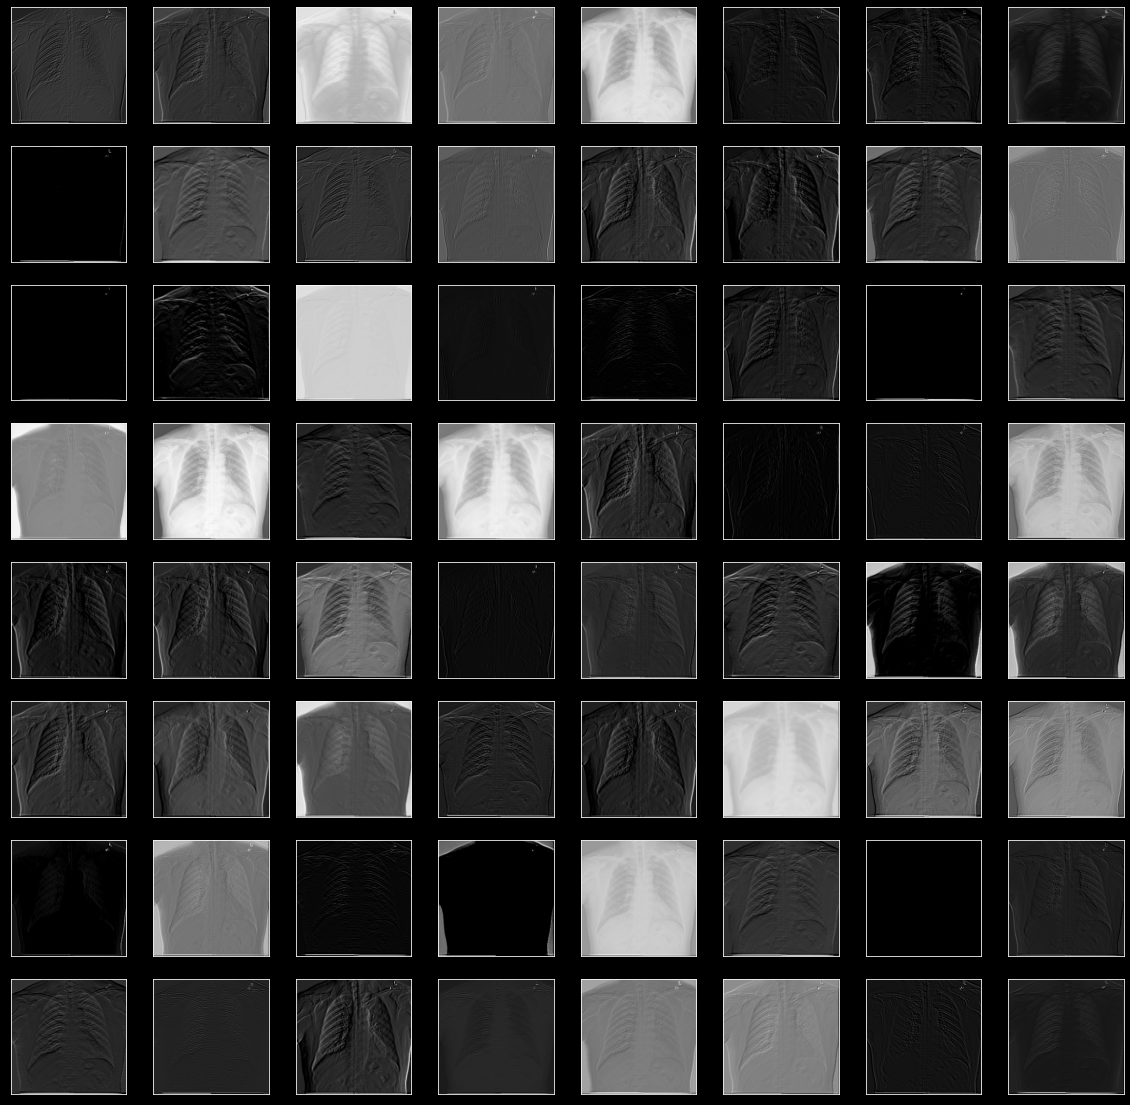

In [11]:
# extract features from a training image and plot some of them
feature_examples = feature_extractor.predict(train_images[:2])
square = 8 # for 8x8 subplots
ix = 1
f = plt.figure(figsize=(20,20))
for _ in range(square):
        for _ in range(square):
                ax = f.add_subplot(square, square, ix, )
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(feature_examples[0,:,:,ix-1], cmap='gray')
                ix+=1
plt.show()

#### Fit the training data to XGBoost Classifier 

In [ ]:
# Load Image Batch
X = train_images
# Extract features from the image 
features = feature_extractor.predict(X)
# Collapse the image batch(here one image) to 1d for the algorithm 
X_in = features.reshape(-1, features.shape[3])
# (Batchsize, SIZE_Y, SIZE_X, Featuremaps) -> (1d array, Featuremaps)
print(f'Features Dimensions before: {features.shape, features.dtype}\nAfter Collapse: {X_in.shape, X_in.dtype}')
# Load mask
Y = train_masks
# Get y in the same shape as X 
Y = Y.reshape(-1)
#Y = np.expand_dims(Y, axis=1)
# Create df for easier handling of 0 pixel values
dataset = pd.DataFrame(X_in)
# Add column for label
dataset['Label'] = Y
# Now drop all rows where pixel value is 0 - because we only need to train where the mask should be
# dataset = dataset[dataset['Label'] != 0]
# redefine X and Y for Model Input
# Drop labelcolumn
y_train = dataset['Label']
print(dataset['Label'].value_counts())
X_train = dataset.drop('Label', axis=1)
X_train = X_train.values # Convert to array for xgboost
y_train = y_train.values # Convert to array for xgboost
le = LabelEncoder()
#le.fit([0,1,2,3])
le.fit([0, 1])
y_train = le.transform(y_train)
print(f'Shape after dropping pixels with value 0: {X_train.shape, X_train.dtype}')
print(f'Mask Shape after preprocessing: {y_train.shape, y_train.dtype, np.unique(y_train)}')
print("Data preprocess DONE!")
# Fit the model to the training data 
model.fit(X_train, y_train)

#### Evaluate the model 

Now lets check out how the model is performing after training on 12 training cases!

In [13]:
#loaded_model = pickle.load(open('model_XG.sav', 'rb'))
# Load and preprocess test image like in the training step
test_img = cv2.imread('C:/Users/mschi/Desktop/Datasets/Chest_Xray_Lung_Masks/Lung Segmentation/CXR_png/CHNCXR_0362_1.png')
test_img = cv2.resize(test_img,(im_height,im_width))
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
test_img = test_img/255
test_img = np.array(test_img)

X_test = np.expand_dims(test_img, axis=0)
# Extract feature maps from test_img
X_test_features = feature_extractor.predict(X_test)
print(X_test_features.shape, X_test_features.dtype)
# transform X_test in shape for xgboost model
X_test_features = X_test_features.reshape(-1, X_test_features.shape[3])
print(f'collapsed shape {X_test_features.shape} datatype: {X_test_features.dtype}')
# now predict the mask
prediction = model.predict(X_test_features)
print(prediction.dtype)

1/1 [==============================] - 0s 34ms/step
(1, 256, 256, 64) float32
collapsed shape (65536, 64) datatype: float32
int32


(65536,) int32 599
(256, 256)


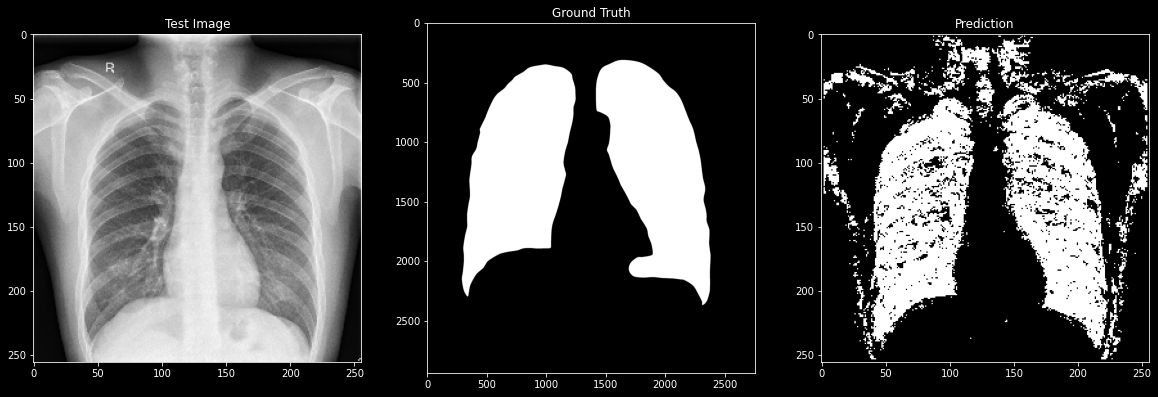

In [15]:
# View the predicted segmented image
print(prediction.shape, prediction.dtype, prediction.argmax())
prediction_image = prediction.reshape((256,256))
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.title("Test Image")
plt.imshow(test_img)
plt.subplot(132)
plt.title("Ground Truth")
test_mask = cv2.imread(test_mask_path)
plt.imshow(test_mask, cmap='gray')
plt.subplot(133)
plt.title("Prediction")
plt.imshow(prediction_image)
plt.imshow(prediction_image, cmap='gray')
print(prediction_image.shape)

After many tuning attempts it looks like this technique is not viable for this dataset with a binary segmentation. 
But it is still a approach to consider when confronted with low amount of images and multiclass semantic segmentation like in the following image taken from https://colab.research.google.com/github/bnsreenu/python_for_image_processing_APEER/blob/master/tutorial125_semantic_segmentation_using_Xfer_learning_VGG_XGBoost.ipynb#scrollTo=Qyl1vxDvPBTP.

<img src="betterresult.png"/>
